In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # removes the warning messages from tensorflow

In [16]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
import pywt
import funcs
import plot_learning_callback
import f1_metric

In [17]:
# use gpu

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [18]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')


In [19]:
#add a dummy dimension
trainReadings = np.expand_dims(trainReadings, axis=2)
validateReadings = np.expand_dims(validateReadings, axis=2)
testReadings = np.expand_dims(testReadings, axis=2)

In [20]:
sigmoidLoss = tf.keras.losses.BinaryCrossentropy() # one output unit
softmaxLoss = tf.keras.losses.CategoricalCrossentropy() # two output units

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, metrics, callbacks

In [22]:
inputShape = (1000, 1)
kernelSize = 20 #how to determine this

In [23]:
convInputLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize, input_shape=inputShape, data_format="channels_last")
convLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize)
batchNormLayer = layers.BatchNormalization(axis=1)
reLULayer = layers.ReLU()
maxPoolLayer = layers.MaxPooling1D(
    pool_size=kernelSize * 2, strides=None) # should the size of the pooling layer be the same as the kernel size

In [24]:
metrics=['accuracy', 
         tf.keras.metrics.FalsePositives(name='false_positives'), 
         tf.keras.metrics.Precision(name='precision'), 
         tf.keras.metrics.Recall(name='recall'), 
         f1_metric.f1]

In [25]:
# adding dropout layer to prevent overfitting

tf.random.set_seed(42)

inputDroppedPercent = 20 # during training, 20 percent of the inputs (to the dropout layer) are randomly dropped
dropoutLayer = layers.Dropout(inputDroppedPercent / 100)
sectionRepeat = 3

In [26]:
modelv2 = Sequential()

for i in range(sectionRepeat):
    modelv2.add(convLayer)
    modelv2.add(batchNormLayer)
    modelv2.add(dropoutLayer) # change to architecture
    modelv2.add(reLULayer)
    modelv2.add(maxPoolLayer)

modelv2.add(layers.Flatten())
modelv2.add(layers.Dense(50, activation='relu'))
modelv2.add(layers.Dense(50, activation='relu'))
modelv2.add(layers.Dense(1, activation='sigmoid'))

In [27]:
modelv2.compile(
    optimizer='adam', loss=sigmoidLoss, 
 metrics=metrics)

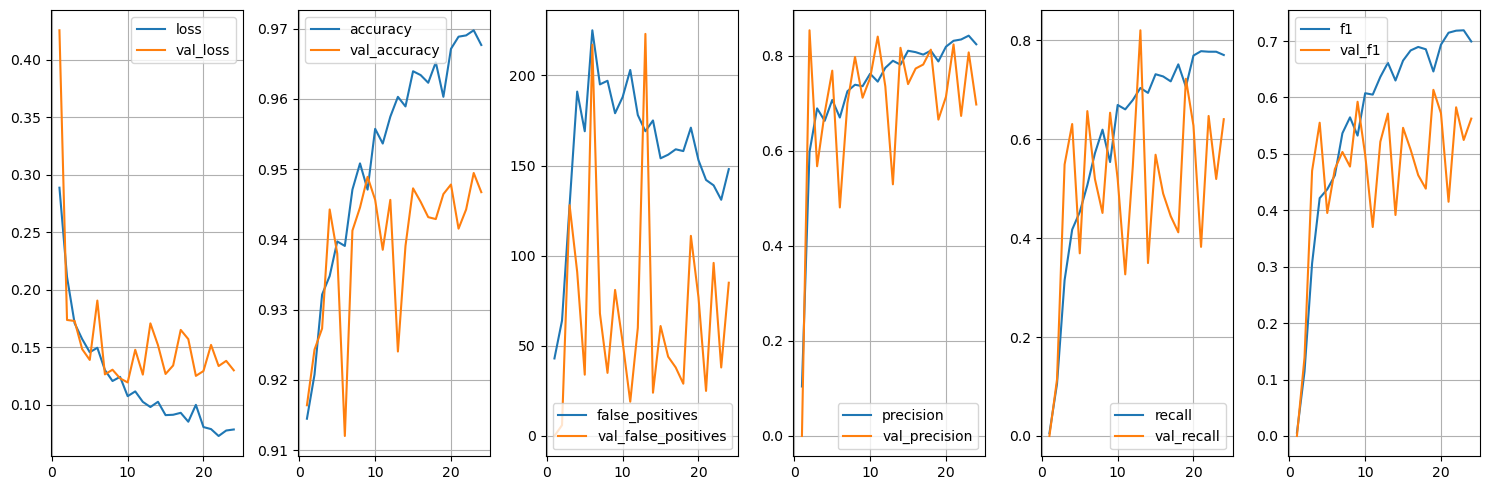

344/344 [==============================] - 10s 28ms/step - loss: 0.0786 - accuracy: 0.9677 - false_positives: 148.0000 - precision: 0.8242 - recall: 0.7703 - f1: 0.6992 - val_loss: 0.1300 - val_accuracy: 0.9467 - val_false_positives: 85.0000 - val_precision: 0.6975 - val_recall: 0.6405 - val_f1: 0.5625
Epoch 25/100
113/344 [========>.....................] - ETA: 6s - loss: 0.0674 - accuracy: 0.9721 - false_positives: 45.0000 - precision: 0.8534 - recall: 0.8239 - f1: 0.7571

KeyboardInterrupt: 

In [28]:
historyv2 = modelv2.fit(
    trainReadings, trainDiagnostic, 
    epochs=100, 
    validation_data=(validateReadings, validateDiagnostic), 
    callbacks=[plot_learning_callback.PlotLearning()]
)

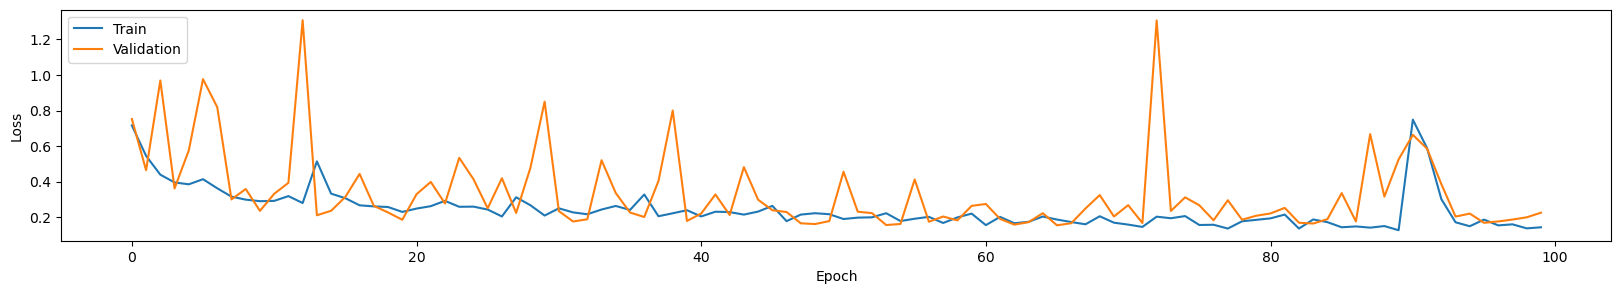

In [22]:
funcs.graph_losses(historyv2, "Loss")

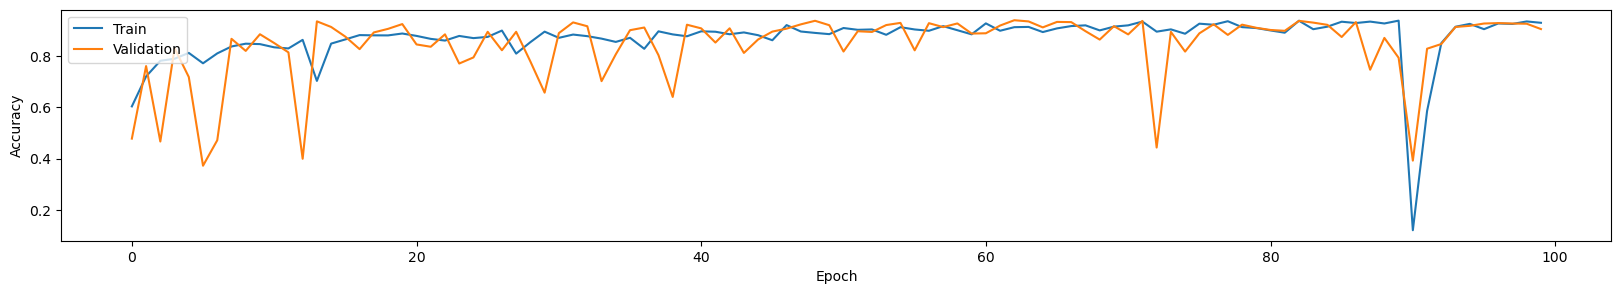

In [23]:
funcs.graph_losses(historyv2, "Accuracy")

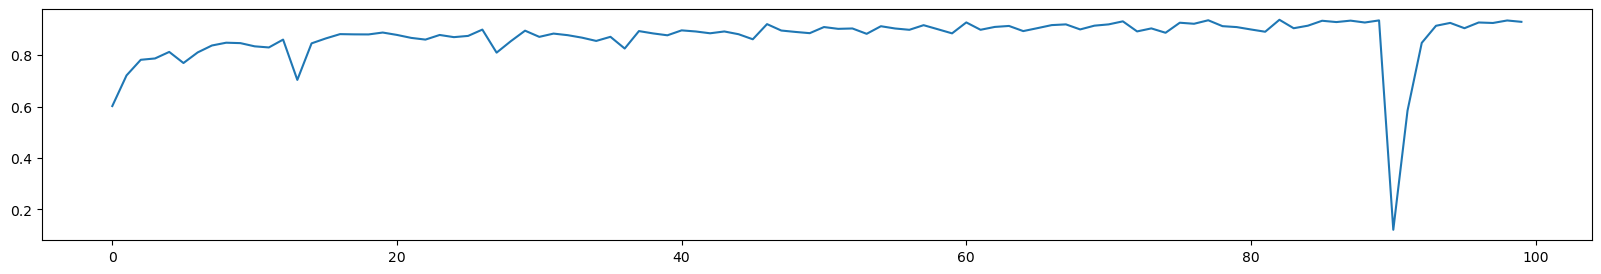

In [24]:
plt.figure(figsize=(20, 3))
plt.plot(historyv2.history['f1'])

In [25]:
historyv2.history.keys()

dict_keys(['loss', 'accuracy', 'false_positives', 'precision', 'f1', 'val_loss', 'val_accuracy', 'val_false_positives', 'val_precision', 'val_f1'])

In [27]:
funcs.evaluate_model(modelv2.predict(testTransform), oneHotTest)

115/115 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3353
           1       0.44      0.83      0.58       307

   micro avg       0.90      0.90      0.90      3660
   macro avg       0.71      0.87      0.76      3660
weighted avg       0.94      0.90      0.91      3660
 samples avg       0.90      0.90      0.90      3660



In [31]:
bestf1Model = tf.keras.models.clone_model(modelv2)

In [32]:
bestf1Model.compile(
    optimizer='adam', loss=softmaxLoss, 
 metrics=metrics)

In [33]:
bestf1Model.load_weights('ckpt/bestf1.hdf5')

In [34]:
bestf1Model.evaluate(testTransform, oneHotTest)

115/115 [==============================] - 1s 7ms/step - loss: 0.1924 - accuracy: 0.9320 - false_positives: 598.0000 - precision: 0.9183 - f1: 0.9319


[0.19238458573818207,
 0.9319671988487244,
 598.0,
 0.9182948470115662,
 0.9318839907646179]

# Create the same network, except trained on the raw ECG data

In [ ]:
rawModel = Sequential()

for i in range(sectionRepeat):
    
    